# PBO deep on Bicycle

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import jax.numpy as jnp
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]
gamma = parameters["gamma"]
# Sample collection
n_samples = parameters["n_samples"]
n_weights = parameters["n_weights"]

# Trainings
layers_dimension = parameters["layers_dimension"]
max_bellman_iterations = parameters["max_bellman_iterations"]
training_steps = parameters["training_steps"]
fitting_steps = parameters["fitting_steps_pbo"]
batch_size_samples = parameters["batch_size_samples"]
batch_size_weights = parameters["batch_size_weights"]
initial_weight_std = parameters["initial_weight_std"]
learning_rate = {"first": parameters["starting_lr_fqi"], "last": parameters["ending_lr_fqi"], "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

# Visualisation of errors and performances
n_omegas = parameters["n_omegas"]
n_thetas = parameters["n_thetas"]
horizon = parameters["horizon"]
max_bellman_iterations_validation = max_bellman_iterations + 10
plot_freq = 100

# Search for an unused seed
max_used_seed = 0
if not os.path.exists("figures/data/PBO_linear_max_linear/"):
    os.makedirs("figures/data/PBO_linear_max_linear/")
for file in os.listdir("figures/data/PBO_linear_max_linear/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[2][:-4])
max_used_seed

# keys
seed = 0 # max_used_seed + 1
env_key = jax.random.PRNGKey(env_seed)
env_key, sample_key = jax.random.split(env_key)
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, pbo_network_key = jax.random.split(key, 3)

## Define environment

In [2]:
import numpy as np

from pbo.environments.bicycle import BicycleEnv


env = BicycleEnv(env_key)

## Collect samples

### Samples on the mesh and with a uniform policy

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
n_steps = 0
positions = [[env.position]]

for idx_sample in range(n_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    action = jax.random.choice(key, env.actions_on_max)
    
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1
    positions[n_episodes].append(env.position)

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing[0] or n_steps >= 20:
        env.reset()
        positions[n_episodes] = np.array(positions[n_episodes])
        positions.append([])
        n_episodes += 1
        n_steps = 0

replay_buffer.cast_to_jax_array()
# assert sum(replay_buffer.rewards == -1) > 0, "No negative reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 375


### Visualize samples

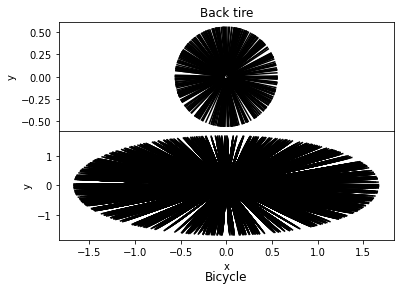

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for episode in range(n_episodes):
    ax1.plot(positions[episode][:, 0], positions[episode][:, 1], color="black")

    for step in range(len(positions[episode])):
        ax2.plot(positions[episode][step, [0, 2]], positions[episode][step, [1, 3]], color="black")


ax1.get_xaxis().set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.set_ylabel("y")
ax1.set_title(f"Back tire")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title(f"Bicycle", y=0, pad=-30, verticalalignment="top")

plt.subplots_adjust(hspace=0)

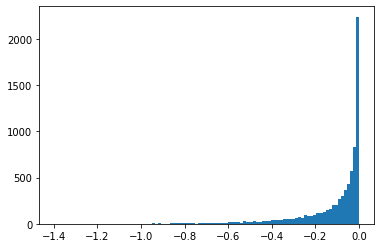

In [5]:
omegas = jnp.linspace(replay_buffer.states[:, 0].min(), replay_buffer.states[:, 0].max(), n_omegas)
omega_dots = jnp.linspace(replay_buffer.states[:, 1].min(), replay_buffer.states[:, 1].max(), n_omegas)

sample_key, key = jax.random.split(sample_key)
sample_omegas_omega_dots = jax.random.choice(key, replay_buffer.states[:, :2], shape=(min(n_samples // 100, 50),), replace=False)

thetas = jnp.linspace(replay_buffer.states[:, 2].min(), replay_buffer.states[:, 2].max(), n_thetas)
theta_dots = jnp.linspace(replay_buffer.states[:, 3].min(), replay_buffer.states[:, 3].max(), n_thetas)

sample_key, key = jax.random.split(sample_key)
sample_thetas_theta_dots = jax.random.choice(key, replay_buffer.states[:, 2:5], shape=(min(n_samples // 100, 50),), replace=False)

sample_key, key = jax.random.split(sample_key)
sample_psis = jax.random.choice(key, replay_buffer.states[:, 4], shape=(min(n_samples // 100, 50),), replace=False)

_ = plt.hist(np.array(replay_buffer.rewards.flatten()), 100)

## Collect weights

In [6]:
from pbo.weights_collection.weights_buffer import WeightsBuffer
from pbo.networks.learnable_q import FullyConnectedQ


weights_buffer = WeightsBuffer()

# Add the validation weights
q = FullyConnectedQ(
    state_dim=5,
    action_dim=2,
    actions_on_max=env.actions_on_max,
    gamma=gamma,
    network_key=q_network_key,
    layers_dimension=layers_dimension,
    zero_initializer=True,
    learning_rate=learning_rate
)
validation_weights = q.to_weights(q.params)
weights_buffer.add(validation_weights)

# Add random weights
while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train deep PBO

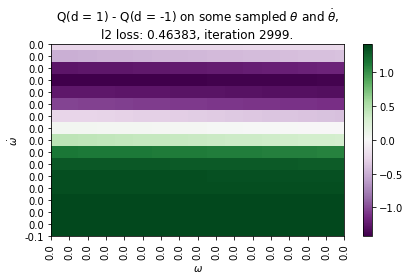

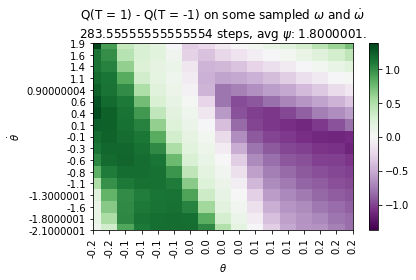

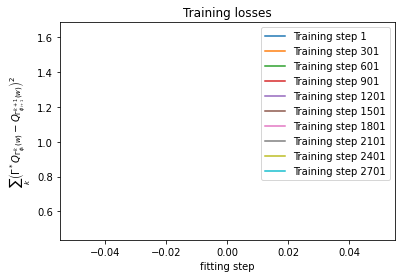

In [7]:
import matplotlib.pyplot as plt

from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearMaxLinearPBO


omega_visu_mesh = TwoDimesionsMesh(omegas, omega_dots, sleeping_time=0, axis_equal=False, zero_centered=True)
theta_visu_mesh = TwoDimesionsMesh(thetas, theta_dots, sleeping_time=0, axis_equal=False, zero_centered=True)
data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearMaxLinearPBO(
    q=q,
    max_bellman_iterations=max_bellman_iterations,
    network_key=pbo_network_key,
    learning_rate=learning_rate,
    initial_weight_std=initial_weight_std
)
importance_iteration = jnp.ones(max_bellman_iterations + 1)

l2_losses = np.ones((training_steps, fitting_steps)) * np.nan

for training_step in range(training_steps):
    params_target = pbo.params

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss

    if (training_step + 1) % plot_freq == 0 or training_step + 1 == training_steps:
        q_weight = validation_weights
        for _ in range(max_bellman_iterations + 3):
            q_weight = pbo(pbo.params, q_weight.reshape((1, -1)))[0]

        metric = env.evaluate(q, q.to_params(q_weight), horizon)

        d_on_omegas = env.q_values_on_omegas(q, q.to_params(q_weight), omegas, omega_dots, sample_thetas_theta_dots, sample_psis)
        T_on_thetas = env.q_values_on_thetas(q, q.to_params(q_weight), sample_omegas_omega_dots, thetas, theta_dots, sample_psis)

        omega_visu_mesh.set_values(d_on_omegas)
        omega_visu_mesh.show(r"Q(d = 1) - Q(d = -1) on some sampled $\theta$ and $\dot{\theta}$," + f"\nl2 loss: {str(jnp.round(cumulative_l2_loss, 5))}, iteration {training_step + 1}.", xlabel=r"$\omega$", ylabel=r"$\dot{\omega}$")
        theta_visu_mesh.set_values(T_on_thetas)
        theta_visu_mesh.show(r"Q(T = 1) - Q(T = -1) on some sampled $\omega$ and $\dot{\omega}$" + f"\n{metric[0]} steps, avg " + r"$\psi$: " + f"{str(jnp.round(metric[1], 1))}.", xlabel=r"$\theta$", ylabel=r"$\dot{\theta}$", clear=False)

for training_step in range(0, training_steps, max(training_steps // 10, 1)):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

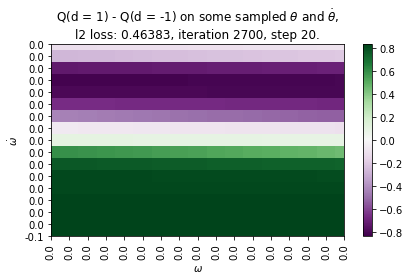

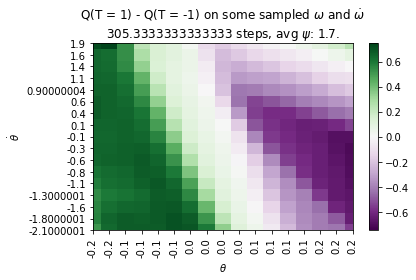

In [8]:
test_bellman_iterations = max_bellman_iterations

q_weight = validation_weights
for _ in range(test_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight.reshape((1, -1)))[0]

metric = env.evaluate(q, q.to_params(q_weight), horizon)

d_on_omegas = env.q_values_on_omegas(q, q.to_params(q_weight), omegas, omega_dots, sample_thetas_theta_dots, sample_psis)
T_on_thetas = env.q_values_on_thetas(q, q.to_params(q_weight), sample_omegas_omega_dots, thetas, theta_dots, sample_psis)

omega_visu_mesh.set_values(d_on_omegas)
omega_visu_mesh.show(r"Q(d = 1) - Q(d = -1) on some sampled $\theta$ and $\dot{\theta}$," + f"\nl2 loss: {str(jnp.round(cumulative_l2_loss, 5))}, iteration {training_step}, step {step + 1}.", xlabel=r"$\omega$", ylabel=r"$\dot{\omega}$")
theta_visu_mesh.set_values(T_on_thetas)
theta_visu_mesh.show(r"Q(T = 1) - Q(T = -1) on some sampled $\omega$ and $\dot{\omega}$" + f"\n{metric[0]} steps, avg " + r"$\psi$: " + f"{str(jnp.round(metric[1], 1))}.", xlabel=r"$\theta$", ylabel=r"$\dot{\theta}$", clear=False)

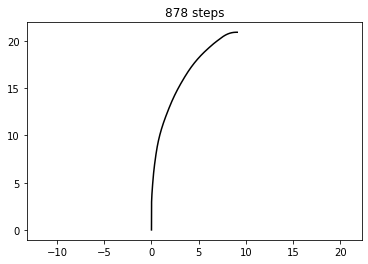

In [9]:
positions = env.collect_positions(q, q.to_params(q_weight), horizon)

plt.plot(positions[:, 0], positions[:, 1], color="black")
plt.axis("equal")
_ = plt.title(f"{positions.shape[0]} steps")

In [10]:
# env.simulate(q, horizon, jnp.array([-0.5, 0]))

## Save the data

In [13]:
from tqdm.notebook import tqdm


metrics = np.ones((max_bellman_iterations_validation + 1, 2)) * np.nan
q_weights = validation_weights

metrics[0] = env.evaluate(q, q.to_params(q_weights), horizon)

for bellman_iteration in tqdm(range(1, max_bellman_iterations_validation + 1)):
    q_weights = pbo(pbo.params, q_weights.reshape((1, -1)))[0]

    metrics[bellman_iteration] = env.evaluate(q, q.to_params(q_weights), horizon)

  0%|          | 0/25 [00:00<?, ?it/s]

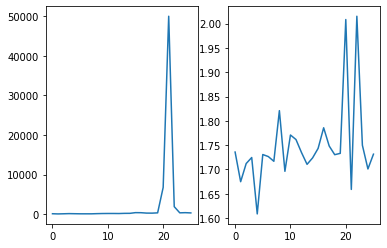

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(range(max_bellman_iterations_validation + 1), metrics[:, 0])
ax2.plot(range(max_bellman_iterations_validation + 1), metrics[:, 1])

In [ ]:
np.save(f"figures/data/PBO_linear_max_linear/{max_bellman_iterations}_metrics_{seed}.npy", metrics)